# Как оценивать квантили распределений "по-быстрому"

*Подготовил Ян Пиле*


## Оценка квантилей алгоритмом t-digest

[Оригинальная статья](https://arxiv.org/pdf/1902.04023.pdf)

Объемы данных часто оказываются настолько велики, что загрузка их целиком в память может быть в лучшем случае затратной, а в худшем — невозможной.

Частая проблема заключается в эффективном вычислении описательных статистик для данных. Хотя загрузка данных в память может быть невозможна, часто данные записаны в множеству файлов, каждый из которых в память влезает.

Ну и вы сами конечно сможете состряпать алгоритм для вычисления статистик типа минимума/среднего значения/максимума для всех данных, не храня данные в памяти (кстати, как это сделать?). Предположим, что вместо этого вам нужно сосчитать 95-й процентиль. Как вы понимаете, знания 95-го процентиля данных в каждом сегменте недостаточно, чтобы вычислить 95-й процентиль данных целиком (метрика-то неаддитивная).

**t-digest** — это вероятностная структура данных, которая позволяет досьтаточно точно оценить произвольные перцентили большого объема распределенных данных без необходимости одновременного хранения их в памяти. Алгоритм работает, используя простую эвристику, которая выдергивает ряда точек, хорошо описывающих (одномерные) данные, и сохраняя эту информацию в самом t-digest'е. Для каждого файла создается один t-digest. Затем, используя ту же эвристику, выбираются новые точки, c помощью которых t-digest'ы отдельных файлов можно соединить. Далее на основе этой структуры можно построить приблизительную функцию распределения, а уже по ней оценить перцентили.

Далее мы эту чудо-структуру разберем.

### Принцип работы: t-digest пытается кластеризовать точки в 1D

Пример кластеров точек:

<img src = "img/clusters-in-1d.png">

Про декоратор [@property](https://advpyneng.readthedocs.io/ru/latest/book/11_oop_method_decorators/property.html#)

In [1]:
from typing import List

class ClusterSummary:
    def __init__(self, center_of_mass: float, n_points: int):
        self._center_of_mass = center_of_mass
        self._n_points = n_points
    @property
    def centroid(self) -> float:
        return self._center_of_mass
    @property
    def weight(self) -> int:
        return self._n_points
    
class Cluster:
    def __init__(self, values: List[float]):
        self._values = values
    def summarise(self) -> ClusterSummary:
        n_points = len(self._values)
        center_of_mass = sum(self._values) / n_points

        return ClusterSummary(center_of_mass, n_points)



Чтобы понять, как осуществляется сжатие, рассмотрим случай, когда все данные влезают в памяти. Представим себе какую-то  возможную одномерную кластеризацию 25 точек данных. 

<img src = "img/weak-and-strong-ordered-clusters.png">

На верхней картинке кластеры обладают свойством, которое авторы статьи [t-digest](https://arxiv.org/abs/1902.04023/) называют строгим упорядочением. Совокупность кластеров называется строго упорядоченной, если в кластере с меньшим центром масс, чем у другого, гарантированно все точки меньше, чем у кластера с большим центром масс.

Свойство строгого упорядочения визуально заметно на верхнем рисунке. Обратите внимание, что все точки данных, принадлежащие синему кластеру, меньше, чем все точки данных, принадлежащие зеленому кластеру, все точки в зеленом кластере меньше, чем в желтом кластере и так далее. Кластеры на нижней части рисунка не обладают строгим упорядочением. Несмотря на то, что центр тяжести желтого кластера больше, чем у зеленого кластера, есть точки, принадлежащие желтому кластеру, которые меньше, чем некоторые точки зеленого кластера.

Остается сложный вопрос про выбор границ кластера. В t-digest'е используется "функцией масштабирования", которая сопоставляет перцентиль с действительным числом, обозначаемым за $k$. Эта функция используется для определения того, сколько точек должно быть в каждом кластере.

При создании кластера перцентилю первой точки данных в кластере присваивается значение $k$ и сохраняется. Далее точки добавляются в кластер (в отсортированном порядке) до тех пор, пока не будет добавлено достаточное количество точек, чтобы значение $k$ увеличилось на 1. На этом этапе кластер считается собранным, запоминается его центроид и вес + создается новый кластер.

Процесс построения кластера показан на рисунке ниже. Обратите внимание, что в кластерах по краям меньше точек, поскольку функция масштабирования "более крутая".

<img src = "img/cluster-building-with-scale-function.gif">

## Реализация

In [5]:
import numpy as np

TAU = 2 * np.pi

def scale_fn(q: float, delta: float) -> float:
    return (delta / TAU) * np.arcsin(2 * q - 1)


def cluster_points(points: np.ndarray, delta: float) -> List[List[float]]:
    n_points = len(points)
    sorted_points = np.sort(points) # n*log(n)
    data_clusters = [[]]
    k_lower = scale_fn(0, delta)
    percentile_increment = 1 / n_points
    centroids = []
    for j, pt in enumerate(sorted_points):
        percentile = (j + 1) * percentile_increment
        k_upper = scale_fn(percentile, delta)
        if k_upper - k_lower < 1:
            data_clusters[-1].append(pt)
        else:
            centroids.append(np.mean(data_clusters[-1]))
            data_clusters.append([pt])
            k_lower = k_upper
    return data_clusters, centroids

## Что насчет этой "функции масштабирования"

**Первое свойство** функции масштабирования – она должна быть определена на интервале $[0,1]$. Это гарантирует, что каждый перцентиль будет сопоставлен с числом $k$. 

**Второе свойство** – функция масштабирования должна монотонно возрастать. Без этого свойства возможно, что изменение никогда не превысит 1, что вообще приведет к отсутствию кластеризации.

А еще важна не только функция масштабирования, но и ее производная. Наклон функции масштабирования определяет, насколько быстро значение $k$ увеличивается с каждым перцентилем. Это определяет количество точек, которые можно добавить в кластер до перехода к новому. Чем больше наклон, тем меньше точек будет разрешено в кластере. Чем меньше наклон, тем больше точек будет включено перед стартом нового кластера.

Чтобы уточнить это понятие, рассмотрим линеаризацию функции масштабирования:

$\Delta k = \dfrac{dk}{dq}\Delta q$

Если обозначить количество точек за $N$ , а кол-во точек в кластере - за $n_{c_i}$, и, кроме того, учесть, что $\Delta k \approx 1$, получится:

$ \dfrac{dq}{dk} \approx \Delta q \approx \dfrac{n_{c_i}}{N} \propto n_{c_i}$

То есть "размер кластера пропорционален производной этой функции"

Для арксинуса это будет $\sqrt{q(1-q)}$ , то есть по краяем точек в кластерах будет мало, а ближе к центру - побольше.


Ну а всего в работе предлагается 4 варианта этих чудо-функций:
<img src = "img/formulae.png" width="500">

Пример:

In [6]:
import seaborn as sns
import matplotlib.pyplot as plt

In [7]:
# !pip install seaborn

In [8]:
n1 = np.random.normal(3,1,10000)
n2 = np.random.normal(2.,0.3,10000)*0.5
n3 = np.random.normal(5,0.5,10000)

total = np.hstack([n1,n2,n3])

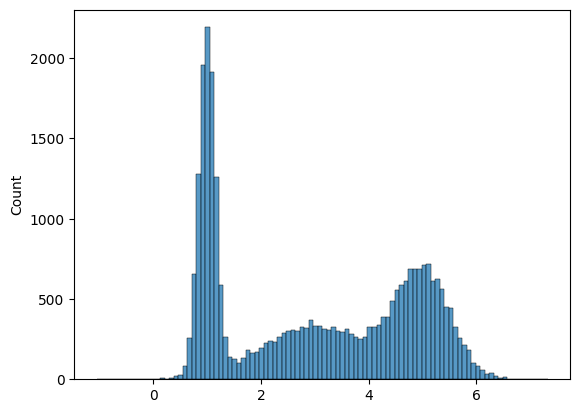

In [9]:
_ = sns.histplot(total, bins = 100)

In [10]:
_, points = cluster_points(total, 100)

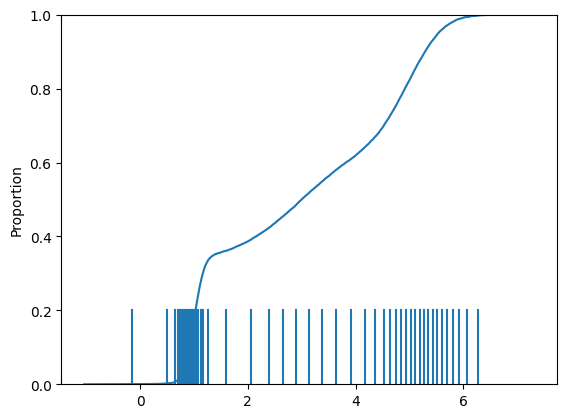

In [11]:
_ = sns.ecdfplot(total)
for xc in points:
    plt.axvline(x=xc, ymax = 0.2)

<Axes: ylabel='Proportion'>

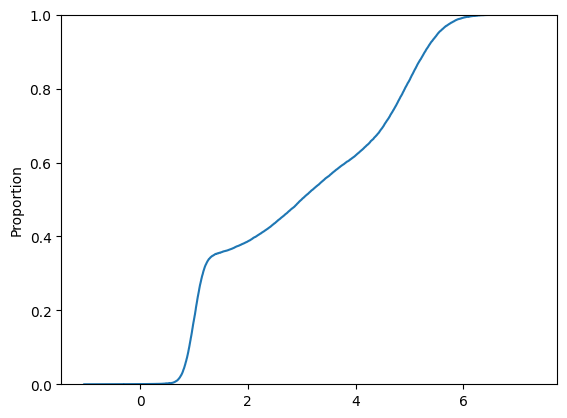

In [12]:
sns.ecdfplot(total)

## Ну, неплохо

## А теперь вариант "[не от криворуких](https://github.com/CamDavidsonPilon/tdigest/tree/master)"

In [13]:
from tdigest import TDigest

In [14]:
digest = TDigest()
digest.batch_update(total)

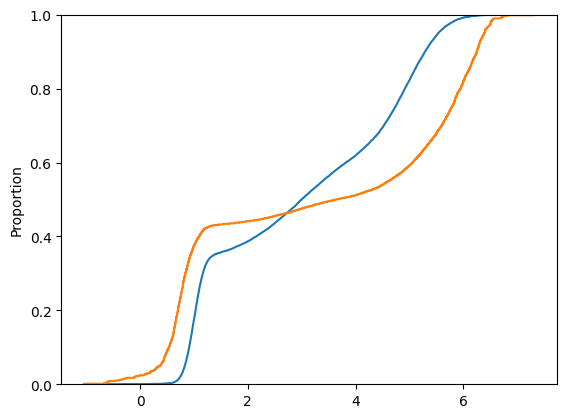

In [15]:
_ = sns.ecdfplot(total)
_ = sns.ecdfplot([i.get('m') for i in digest.centroids_to_list()])

In [18]:
digest.percentile(75)

4.733673348392217

In [19]:
np.percentile(total, 75)

4.733734714702949

## Как получаются "более тонкие" квантили

Взяли имеющиеся - бахнули линейную интерполяцию и готово.

<img src = "img/percentile-estimation.gif">

## Как помержить друг с другом кластеры

In [102]:
def merge_cluster_summaries(c1: ClusterSummary, c2: ClusterSummary):
    w1 = c1.weight / (c1.weight + c2.weight)
    w2 = c2.weight / (c1.weight + c2.weight)
    new_centroid = w1 * c1.centroid + w2 * c2.centroid
    new_weight = c1.weight + c2.weight
    return ClusterSummary(new_centroid, new_weight)

In [1]:
!pip install tdigest

  Using cached tdigest-0.5.2.2-py3-none-any.whl.metadata (4.9 kB)
  Using cached accumulation_tree-0.6.2-cp311-cp311-macosx_11_0_arm64.whl
  Using cached pyudorandom-1.0.0-py3-none-any.whl
Using cached tdigest-0.5.2.2-py3-none-any.whl (9.4 kB)
